In [ ]:
!pip install geopandas
!pip install folium
!pip install lightgbm
!pip install utm
!pip install geojson 
!pip install haversine

# folium 한글 설치
!pip install git+https://github.com/python-visualization/branca.git@master

# 시각화 도구 설치
!pip install plotnine #R 시각화 
!pip install mglearn
!pip install folium #지도 시각화 

In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
!pip install pickle5

In [1]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [2]:
import pandas as pd
import mglearn
import pickle5 as pickle
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
import folium 
import geopandas as gpd
import math
from tqdm.notebook import tqdm
import utm
from shapely.geometry import Point, Polygon
from haversine import haversine
from plotnine import *

## 데이터로드

In [3]:
df_demand =pd.read_pickle('/content/drive/My Drive/Project/Seoul/지수_결과/1014수정_인프라지수.pickle')[['행정동코드', '행정동', 'new수요지수','100분위']]
df_demand['100분위'] = df_demand['100분위'].astype(int)
df_demand['행정동코드'] = df_demand['행정동코드'].astype(int)
df_demand

,행정동코드,행정동,new수요지수,100분위
0,1165065100,양재1동,2.911910e-05,2
1,1153078000,오류제2동,7.399572e-05,6
2,1150063000,방화제1동,9.837376e-05,8
3,1138069000,진관동,5.887938e-05,5
4,1138062500,역촌동,1.043019e-04,8
...,...,...,...,...
419,1114057000,필동,5.739099e-07,1
420,1114059000,광희동,1.084052e-06,1
421,1111054000,삼청동,1.052168e-06,1
422,1114060500,을지로동,1.870521e-07,1


In [4]:
df_demand.sort_values(by = '100분위', ascending=False)

,행정동코드,행정동,new수요지수,100분위
316,1165066000,내곡동,2.459866e-04,10
290,1130560300,번2동,2.247890e-04,10
132,1121586000,구의제2동,1.355633e-04,10
28,1135070000,상계8동,1.697615e-04,10
281,1171067000,잠실2동,1.682111e-04,10
...,...,...,...,...
389,1141072000,북가좌제2동,4.375932e-07,1
390,1165058100,반포4동,2.956245e-07,1
394,1150060500,가양제3동,1.605111e-05,1
395,1150056000,화곡제3동,4.007872e-07,1


In [5]:
df_alone = pd.read_csv("/content/drive/My Drive/Project/Seoul/지수_결과/역수취한 최종 돌봄 틈새공백 인구.csv")
df_alone

,Unnamed: 0,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
0,0,1117051000,용산구,후암동,3.608846,0.003152,4
1,1,1117057000,용산구,원효로2동,3.445290,0.003107,4
2,2,1117064000,용산구,이촌2동,1.544051,0.003132,1
3,3,1117066000,용산구,이태원2동,1.508517,0.003337,1
4,4,1117069000,용산구,서빙고동,3.587631,0.003040,4
...,...,...,...,...,...,...,...
419,419,1120072000,성동구,송정동,1.773041,0.003189,2
420,420,1120067000,성동구,성수2가1동,2.749154,0.003167,3
421,421,1120053500,성동구,왕십리도선동,6.841889,0.003455,8
422,422,1120064500,성동구,옥수동,8.163456,0.003818,8


In [6]:
df_alone.sort_values(by = '돌봄틈새공백 분위', ascending=False)

,Unnamed: 0,행정동코드,시군구명,행정동명,돌봄 틈새공백 인구,동별 돌봄 틈새공백 인구 비율,돌봄틈새공백 분위
92,92,1147051000,양천구,목1동,19.277092,0.003953,10
374,374,1135062100,노원구,중계1동,17.296338,0.003811,10
283,283,1171068000,송파구,잠실3동,14.454883,0.003526,10
98,98,1168072000,강남구,일원본동,11.540119,0.003435,10
310,310,1121581000,광진구,광장동,18.154043,0.003318,10
...,...,...,...,...,...,...,...
309,309,1121571000,광진구,화양동,1.415339,0.002912,1
50,50,1114052000,중구,소공동,0.691716,0.003953,1
213,213,1162069500,관악구,신림동,1.142016,0.003235,1
47,47,1111064000,종로구,이화동,1.050374,0.002959,1


In [7]:
# 소득 k=3
df_income = pd.read_csv('/content/drive/My Drive/Project/Seoul/지수_결과/행정동별_소득분위k=3_최종_분위수정.csv')
df_income

,행정동코드,읍면동명,시군구명,추정소득 k=3,소득분위
0,1171063100,가락1동,송파구,0.514075,3
1,1171063200,가락2동,송파구,-0.044838,5
2,1171062000,가락본동,송파구,0.131003,4
3,1153059500,가리봉동,구로구,-1.059104,10
4,1154551000,가산동,금천구,-0.801810,10
...,...,...,...,...,...
419,1117058000,효창동,용산구,-0.275550,6
420,1117051000,후암동,용산구,-0.571142,8
421,1123072000,휘경제1동,동대문구,-0.387180,7
422,1123073000,휘경제2동,동대문구,-0.261534,6


In [8]:
df_income.sort_values(by = '소득분위', ascending=False)

,행정동코드,읍면동명,시군구명,추정소득 k=3,소득분위
344,1114058000,장충동,중구,-1.131973,10
79,1132052100,도봉제1동,도봉구,-0.847441,10
254,1147061100,신월7동,양천구,-1.060604,10
36,1138056000,구산동,은평구,-0.853340,10
262,1132066000,쌍문제1동,도봉구,-0.984369,10
...,...,...,...,...,...
271,1168054500,압구정동,강남구,2.543468,1
59,1168053100,논현2동,강남구,1.270274,1
266,1144055500,아현동,마포구,1.401888,1
187,1144066000,서교동,마포구,1.780954,1


#### merge

In [9]:
df_demand['행정동코드'] = df_demand['행정동코드'].astype(int)
df_alone['행정동코드'] = df_alone['행정동코드'].astype(int)
df_income['행정동코드'] = df_income['행정동코드'].astype(int)


df_1 = df_demand.merge(df_alone, on = '행정동코드')
df_final = df_1.merge(df_income, on='행정동코드')

df_tsne = df_final.copy()
df_tsne = df_tsne[['행정동코드','시군구명_x', '행정동', 'new수요지수', '돌봄 틈새공백 인구','추정소득 k=3' ]]
df_tsne.columns = ['행정동코드', '시군구명', '행정동명', '인프라지수', '틈새돌봄인구', '추정소득']

df_final = df_final[['행정동코드', '시군구명_x', '행정동명', '100분위','돌봄틈새공백 분위','소득분위']]
df_final.columns = ['행정동코드', '시군구명', '행정동명', '인프라지수_분위','틈새돌봄인구_분위','소득_분위']

In [10]:
df_tsne

,행정동코드,시군구명,행정동명,인프라지수,틈새돌봄인구,추정소득
0,1165065100,서초구,양재1동,2.911910e-05,20.058894,0.651861
1,1153078000,구로구,오류제2동,7.399572e-05,15.328145,0.165374
2,1150063000,강서구,방화제1동,9.837376e-05,17.737957,-0.048502
3,1138069000,은평구,진관동,5.887938e-05,24.789692,-0.214553
4,1138062500,은평구,역촌동,1.043019e-04,11.221457,-1.179392
...,...,...,...,...,...,...
419,1114057000,중구,필동,5.739099e-07,0.464104,-0.509803
420,1114059000,중구,광희동,1.084052e-06,0.438543,0.281250
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,-0.023982
422,1114060500,중구,을지로동,1.870521e-07,0.108253,-0.692454


In [11]:
df_final

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위
0,1165065100,서초구,양재1동,2,10,2
1,1153078000,구로구,오류2동,6,10,4
2,1150063000,강서구,방화1동,8,10,5
3,1138069000,은평구,진관동,5,10,5
4,1138062500,은평구,역촌동,8,10,10
...,...,...,...,...,...,...
419,1114057000,중구,필동,1,1,8
420,1114059000,중구,광희동,1,1,3
421,1111054000,종로구,삼청동,1,1,4
422,1114060500,중구,을지로동,1,1,9


## t-NSE

In [12]:
X = df_tsne[['인프라지수', '틈새돌봄인구', '추정소득']]

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

features = ['인프라지수', '틈새돌봄인구', '추정소득']
pd.DataFrame(X_scale, columns = features).head()

,인프라지수,틈새돌봄인구,추정소득
0,0.112843,0.771715,0.375769
1,0.287029,0.589386,0.277766
2,0.381651,0.682263,0.234681
3,0.228355,0.954046,0.201231
4,0.404660,0.431110,0.006865


In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate= 100, perplexity=50) 

#학습도니 tsne 모델을 이용해 data 변환: 차원 축소
data_tsne = tsne.fit_transform(X_scale)
print("원본 데이터의 형태: ", str(X_scale.shape))
print("축소된 데이터의 형태: ", str(data_tsne.shape))

원본 데이터의 형태:  (424, 3)
축소된 데이터의 형태:  (424, 2)


쿨백-라이블러 발산(Kullback–Leibler divergence, KLD)은 두 확률분포의 차이를 계산하는 데에 사용하는 함수로, 어떤 이상적인 분포에 대해, 그 분포를 근사하는 다른 분포를 사용해 샘플링을 한다면 발생할 수 있는 정보 엔트로피 차이를 계산한다. 상대 엔트로피(relative entropy), 정보 획득량(information gain), 인포메이션 다이버전스(information divergence)라고도 한다.

In [15]:
tsne.kl_divergence_

0.5698678493499756

In [16]:
result = pd.DataFrame(data_tsne, columns = ['tsne1', 'tsne2'])
result

,tsne1,tsne2
0,-14.593328,3.090909
1,-13.322856,1.598830
2,-14.121377,0.759749
3,-15.329083,2.187745
4,-10.546282,-3.288561
...,...,...
419,13.180804,6.171489
420,14.740479,2.753958
421,14.045692,4.068134
422,13.188966,6.750918


## 기존 선형결합(2,2,1)

In [17]:
# 돌봄에 많이 
a, b, c = 2, 2, 1

df_final['수요지수'] = df_final['인프라지수_분위']*a + df_final['틈새돌봄인구_분위']*b + df_final['소득_분위']*c
df_final = df_final.sort_values(by = '수요지수', ascending = False).reset_index().drop('index', axis=1)
df_final

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수
0,1135059500,노원구,공릉1동,10,9,10,48
1,1138062500,은평구,역촌동,8,10,10,46
2,1147064000,양천구,신정3동,10,10,6,46
3,1150054000,강서구,화곡1동,9,9,10,46
4,1150051000,강서구,염창동,9,10,7,45
...,...,...,...,...,...,...,...
419,1111064000,종로구,이화동,1,1,3,7
420,1117064000,용산구,이촌2동,2,1,1,7
421,1114059000,중구,광희동,1,1,3,7
422,1174069000,강동구,둔촌1동,1,1,2,6


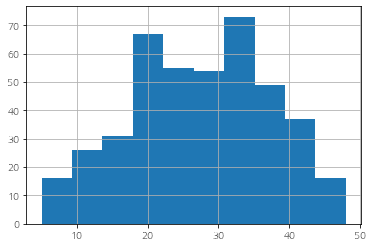

In [18]:
df_final['수요지수'].hist()

### 현재 키움센터 개수와 비교

공식 = 동별 점수*91 / Sum(동별 점수의 합) - 현재 동별 센터의 개수

In [19]:
df_supply = pd.read_pickle('/content/drive/My Drive/Project/Seoul/가공데이터/행정동별_주변공적돌봄시설.pickle')
df_supply

,행정동코드,시군구명,읍면동명,키움센터_상시돌봄정원,키움센터_일시돌봄정원,키움센터_개수,초등돌봄교실_이용인원,초등돌봄교실_교실개수,지역아동센터_정원,지역아동센터_개수,방과후아카데미_정원,방과후아카데미_개수
0,1111053000,종로구,사직동,0.0,0.0,0.0,65.0,3.0,0.0,0.0,0.0,0.0
1,1111054000,종로구,삼청동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1111055000,종로구,부암동,0.0,0.0,0.0,111.0,5.0,0.0,0.0,0.0,0.0
3,1111056000,종로구,평창동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1111057000,종로구,무악동,0.0,0.0,0.0,80.0,4.0,35.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
420,1174070000,강동구,둔촌제2동,0.0,0.0,0.0,153.0,7.0,50.0,1.0,0.0,0.0
421,1174057000,강동구,암사제1동,20.0,4.0,1.0,97.0,4.0,71.0,2.0,0.0,0.0
422,1174061000,강동구,천호제2동,0.0,0.0,0.0,100.0,4.0,59.0,2.0,0.0,0.0
423,1174068500,강동구,길동,0.0,0.0,0.0,255.0,13.0,129.0,5.0,0.0,0.0


In [20]:
Sum = df_final['수요지수'].sum()
print(Sum)

df_final['동별_필요센터수'] = df_final[['수요지수']].apply(lambda x: x*400 / Sum)
df_final

11660


,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수
0,1135059500,노원구,공릉1동,10,9,10,48,1.646655
1,1138062500,은평구,역촌동,8,10,10,46,1.578045
2,1147064000,양천구,신정3동,10,10,6,46,1.578045
3,1150054000,강서구,화곡1동,9,9,10,46,1.578045
4,1150051000,강서구,염창동,9,10,7,45,1.543739
...,...,...,...,...,...,...,...,...
419,1111064000,종로구,이화동,1,1,3,7,0.240137
420,1117064000,용산구,이촌2동,2,1,1,7,0.240137
421,1114059000,중구,광희동,1,1,3,7,0.240137
422,1174069000,강동구,둔촌1동,1,1,2,6,0.205832


In [21]:
df_merge = df_final.merge(df_supply[['행정동코드', '키움센터_개수']])
df_merge['공급미달량'] = df_merge[['동별_필요센터수', '키움센터_개수']].apply(lambda x: x['동별_필요센터수']-x['키움센터_개수'], axis=1)
df_merge

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량
0,1135059500,노원구,공릉1동,10,9,10,48,1.646655,1.0,0.646655
1,1138062500,은평구,역촌동,8,10,10,46,1.578045,1.0,0.578045
2,1147064000,양천구,신정3동,10,10,6,46,1.578045,1.0,0.578045
3,1150054000,강서구,화곡1동,9,9,10,46,1.578045,0.0,1.578045
4,1150051000,강서구,염창동,9,10,7,45,1.543739,1.0,0.543739
...,...,...,...,...,...,...,...,...,...,...
419,1111064000,종로구,이화동,1,1,3,7,0.240137,0.0,0.240137
420,1117064000,용산구,이촌2동,2,1,1,7,0.240137,1.0,-0.759863
421,1114059000,중구,광희동,1,1,3,7,0.240137,0.0,0.240137
422,1174069000,강동구,둔촌1동,1,1,2,6,0.205832,0.0,0.205832


In [22]:
# 1순위 -> 먼저 설치해야 함
pt_list = np.percentile(df_merge[['수요지수']],[i*10 for i in range(2,10,2)]).tolist()

df_merge['수요지수_우선순위'] = 0
df_merge.loc[df_merge['수요지수'] <= pt_list[0], '수요지수_우선순위'] = 5
df_merge.loc[(df_merge['수요지수'] > pt_list[0]) & (df_merge['수요지수'] <= pt_list[1]),'수요지수_우선순위'] = 4
df_merge.loc[(df_merge['수요지수'] > pt_list[1]) & (df_merge['수요지수'] <= pt_list[2]),'수요지수_우선순위'] = 3
df_merge.loc[(df_merge['수요지수'] > pt_list[2]) & (df_merge['수요지수'] <= pt_list[3]),'수요지수_우선순위'] = 2
df_merge.loc[(df_merge['수요지수'] > pt_list[3]),'수요지수_우선순위'] = 1
df_merge

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위
0,1135059500,노원구,공릉1동,10,9,10,48,1.646655,1.0,0.646655,1
1,1138062500,은평구,역촌동,8,10,10,46,1.578045,1.0,0.578045,1
2,1147064000,양천구,신정3동,10,10,6,46,1.578045,1.0,0.578045,1
3,1150054000,강서구,화곡1동,9,9,10,46,1.578045,0.0,1.578045,1
4,1150051000,강서구,염창동,9,10,7,45,1.543739,1.0,0.543739,1
...,...,...,...,...,...,...,...,...,...,...,...
419,1111064000,종로구,이화동,1,1,3,7,0.240137,0.0,0.240137,5
420,1117064000,용산구,이촌2동,2,1,1,7,0.240137,1.0,-0.759863,5
421,1114059000,중구,광희동,1,1,3,7,0.240137,0.0,0.240137,5
422,1174069000,강동구,둔촌1동,1,1,2,6,0.205832,0.0,0.205832,5


In [23]:
# 1순위 -> 먼저 설치해야 함
pt_list = np.percentile(df_merge[['공급미달량']],[i*10 for i in range(2,10,2)]).tolist()

df_merge['공급미달량_우선순위'] = 0
df_merge.loc[df_merge['공급미달량'] <= pt_list[0], '공급미달량_우선순위'] = 5
df_merge.loc[(df_merge['공급미달량'] > pt_list[0]) & (df_merge['공급미달량'] <= pt_list[1]),'공급미달량_우선순위'] = 4
df_merge.loc[(df_merge['공급미달량'] > pt_list[1]) & (df_merge['공급미달량'] <= pt_list[2]),'공급미달량_우선순위'] = 3
df_merge.loc[(df_merge['공급미달량'] > pt_list[2]) & (df_merge['공급미달량'] <= pt_list[3]),'공급미달량_우선순위'] = 2
df_merge.loc[(df_merge['공급미달량'] > pt_list[3]),'공급미달량_우선순위'] = 1
df_merge

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위,공급미달량_우선순위
0,1135059500,노원구,공릉1동,10,9,10,48,1.646655,1.0,0.646655,1,4
1,1138062500,은평구,역촌동,8,10,10,46,1.578045,1.0,0.578045,1,4
2,1147064000,양천구,신정3동,10,10,6,46,1.578045,1.0,0.578045,1,4
3,1150054000,강서구,화곡1동,9,9,10,46,1.578045,0.0,1.578045,1,1
4,1150051000,강서구,염창동,9,10,7,45,1.543739,1.0,0.543739,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1111064000,종로구,이화동,1,1,3,7,0.240137,0.0,0.240137,5,5
420,1117064000,용산구,이촌2동,2,1,1,7,0.240137,1.0,-0.759863,5,5
421,1114059000,중구,광희동,1,1,3,7,0.240137,0.0,0.240137,5,5
422,1174069000,강동구,둔촌1동,1,1,2,6,0.205832,0.0,0.205832,5,5


## t-NSE (2,2,1)

In [24]:
df_tsne_1 = df_tsne.merge(df_merge[['행정동코드', '공급미달량_우선순위', '수요지수_우선순위']], left_on='행정동코드', right_on='행정동코드')
df_tsne_1

,행정동코드,시군구명,행정동명,인프라지수,틈새돌봄인구,추정소득,공급미달량_우선순위,수요지수_우선순위
0,1165065100,서초구,양재1동,2.911910e-05,20.058894,0.651861,5,3
1,1153078000,구로구,오류제2동,7.399572e-05,15.328145,0.165374,5,2
2,1150063000,강서구,방화제1동,9.837376e-05,17.737957,-0.048502,4,1
3,1138069000,은평구,진관동,5.887938e-05,24.789692,-0.214553,5,2
4,1138062500,은평구,역촌동,1.043019e-04,11.221457,-1.179392,4,1
...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,5.739099e-07,0.464104,-0.509803,4,5
420,1114059000,중구,광희동,1.084052e-06,0.438543,0.281250,5,5
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,-0.023982,5,5
422,1114060500,중구,을지로동,1.870521e-07,0.108253,-0.692454,4,5


In [25]:
X = df_tsne_1[['인프라지수', '틈새돌봄인구', '추정소득']]

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

features = ['인프라지수', '틈새돌봄인구', '추정소득']
pd.DataFrame(X_scale, columns = features).head()

,인프라지수,틈새돌봄인구,추정소득
0,0.112843,0.771715,0.375769
1,0.287029,0.589386,0.277766
2,0.381651,0.682263,0.234681
3,0.228355,0.954046,0.201231
4,0.404660,0.431110,0.006865


In [49]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate= 100 , perplexity=50) 

#학습도니 tsne 모델을 이용해 data 변환: 차원 축소
data_tsne = tsne.fit_transform(X_scale)
print("원본 데이터의 형태: ", str(X_scale.shape))
print("축소된 데이터의 형태: ", str(data_tsne.shape))

원본 데이터의 형태:  (424, 3)
축소된 데이터의 형태:  (424, 2)


쿨백-라이블러 발산(Kullback–Leibler divergence, KLD)은 두 확률분포의 차이를 계산하는 데에 사용하는 함수로, 어떤 이상적인 분포에 대해, 그 분포를 근사하는 다른 분포를 사용해 샘플링을 한다면 발생할 수 있는 정보 엔트로피 차이를 계산한다. 상대 엔트로피(relative entropy), 정보 획득량(information gain), 인포메이션 다이버전스(information divergence)라고도 한다.

In [50]:
tsne.kl_divergence_

0.49510374665260315

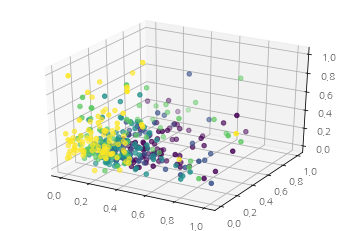

In [51]:
# 원본
scaled = pd.DataFrame(X_scale)
x, y, z = scaled[0], scaled[1], scaled[2]

fig = plt.figure()
ax = fig.gca(projection = '3d')
ax.scatter(x, y, z, c = df_merge['수요지수_우선순위'])
plt.show()

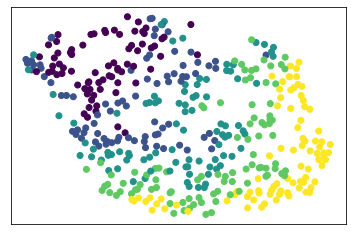

In [52]:
figure, axesSubplot = plt.subplots()

axesSubplot.scatter(data_tsne[:, 0], data_tsne[:, 1], c = df_tsne_1['수요지수_우선순위'])

axesSubplot.set_xticks(())

axesSubplot.set_yticks(())
plt.show()

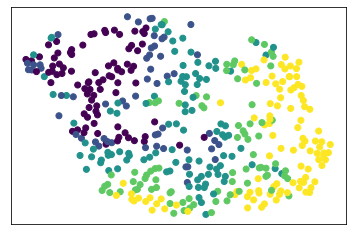

In [53]:
figure, axesSubplot = plt.subplots()

axesSubplot.scatter(data_tsne[:, 0], data_tsne[:, 1], c = df_tsne_2['수요지수_우선순위'])

axesSubplot.set_xticks(())

axesSubplot.set_yticks(())
plt.show()

In [63]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate= 400, n_components=1, perplexity=150) 

#학습된 tsne 모델을 이용해 data 변환: 차원 축소
data_tsne = tsne.fit_transform(X_scale)
print("원본 데이터의 형태: ", str(X_scale.shape))
print("축소된 데이터의 형태: ", str(data_tsne.shape))

원본 데이터의 형태:  (424, 3)
축소된 데이터의 형태:  (424, 1)


In [64]:
tsne.kl_divergence_

0.5532181262969971

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


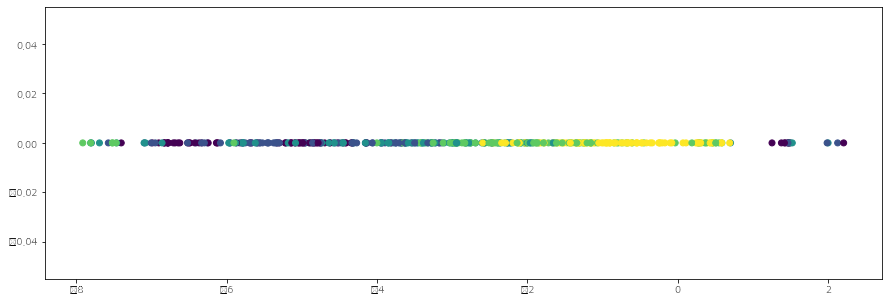

In [65]:
val = 0
plt.figure(figsize=(15,5))
plt.scatter(data_tsne,np.zeros_like(data_tsne) + val,  c = df_tsne_1['수요지수_우선순위'])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


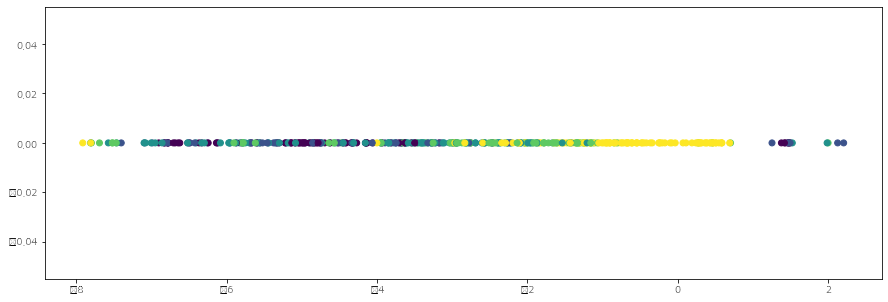

In [70]:
val = 0
plt.figure(figsize=(15,5))
plt.scatter(data_tsne,np.zeros_like(data_tsne) + val,  c = df_tsne_2['수요지수_우선순위'])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


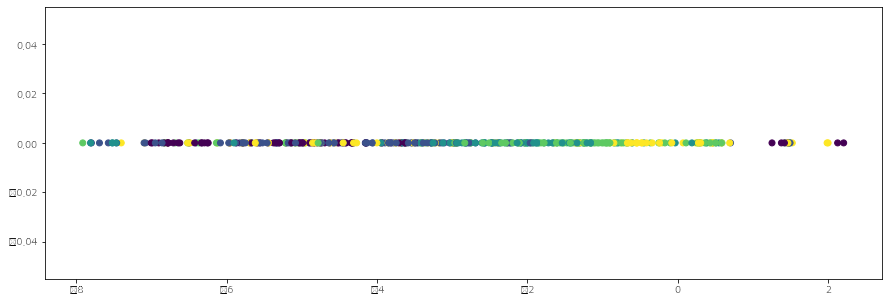

In [71]:
val = 0
plt.figure(figsize=(15,5))
plt.scatter(data_tsne,np.zeros_like(data_tsne) + val,  c = df_tsne_1['공급미달량_우선순위'])

In [72]:
df_tsne_result1 = pd.concat([df_tsne_2, pd.DataFrame(data_tsne.flatten(), columns = ['tsne'])], axis=1)
df_tsne_result1

,행정동코드,시군구명,행정동명,인프라지수,틈새돌봄인구,추정소득,공급미달량_우선순위,수요지수_우선순위,tsne
0,1165065100,서초구,양재1동,2.911910e-05,20.058894,0.651861,5,4,2.001390
1,1153078000,구로구,오류제2동,7.399572e-05,15.328145,0.165374,5,2,-6.784984
2,1150063000,강서구,방화제1동,9.837376e-05,17.737957,-0.048502,5,1,-6.827137
3,1138069000,은평구,진관동,5.887938e-05,24.789692,-0.214553,5,2,-7.093767
4,1138062500,은평구,역촌동,1.043019e-04,11.221457,-1.179392,4,1,-5.049941
...,...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,5.739099e-07,0.464104,-0.509803,4,5,-0.900942
420,1114059000,중구,광희동,1.084052e-06,0.438543,0.281250,5,5,-0.480805
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,-0.023982,5,5,-0.668544
422,1114060500,중구,을지로동,1.870521e-07,0.108253,-0.692454,4,5,-0.932118


In [74]:
df_tsne_result1.sort_values('tsne',ascending=False)

,행정동코드,시군구명,행정동명,인프라지수,틈새돌봄인구,추정소득,공급미달량_우선순위,수요지수_우선순위,tsne
281,1171067000,송파구,잠실2동,0.000168,25.982035,2.104911,1,2,2.208232
271,1147055000,양천구,목5동,0.000077,25.019771,-0.042728,1,2,2.128183
0,1165065100,서초구,양재1동,0.000029,20.058894,0.651861,5,4,2.001390
7,1168070000,강남구,세곡동,0.000069,19.999723,0.909065,5,3,1.988009
127,1114068000,중구,중림동,0.000223,2.630742,0.235092,5,3,1.525265
...,...,...,...,...,...,...,...,...,...
344,1168065600,강남구,도곡2동,0.000039,13.995973,2.781268,3,4,-7.691619
312,1168067000,강남구,개포2동,0.000073,6.558075,2.999452,3,4,-7.798630
359,1168054500,강남구,압구정동,0.000006,9.435525,2.543468,4,5,-7.807507
330,1165057000,서초구,반포2동,0.000075,11.197145,3.750568,3,3,-7.808980


In [130]:
# 2, 2, 1 기준 

mask1 = df_merge['행정동코드'] == 1171056600
mask2 = df_merge['행정동코드'] == 1168072000
mask3 = df_merge['행정동코드'] == 1165066000	
mask4 = df_merge['행정동코드'] == 1132052100
mask5 = df_merge['행정동코드'] == 1171067000

df_merge[mask1|mask2|mask3|mask4|mask5]

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위,공급미달량_우선순위
42,1171067000,송파구,잠실2동,10,10,1,41,1.406518,0.0,1.406518,1,1
43,1168072000,강남구,일원본동,10,10,1,41,1.406518,1.0,0.406518,1,4
74,1171056600,송파구,오륜동,10,8,1,37,1.269297,0.0,1.269297,2,1
75,1165066000,서초구,내곡동,10,8,1,37,1.269297,0.0,1.269297,2,1
93,1132052100,도봉구,도봉1동,10,3,10,36,1.234991,1.0,0.234991,2,5


In [ ]:
df_merge.sort_values('수요지수',ascending=False)

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위,공급미달량_우선순위
0,1135059500,노원구,공릉1동,10,9,10,48,1.646655,1.0,0.646655,1,4
2,1147064000,양천구,신정3동,10,10,6,46,1.578045,1.0,0.578045,1,4
3,1150054000,강서구,화곡1동,9,9,10,46,1.578045,0.0,1.578045,1,1
1,1138062500,은평구,역촌동,8,10,10,46,1.578045,1.0,0.578045,1,4
4,1150051000,강서구,염창동,9,10,7,45,1.543739,1.0,0.543739,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1111064000,종로구,이화동,1,1,3,7,0.240137,0.0,0.240137,5,5
420,1117064000,용산구,이촌2동,2,1,1,7,0.240137,1.0,-0.759863,5,5
421,1114059000,중구,광희동,1,1,3,7,0.240137,0.0,0.240137,5,5
422,1174069000,강동구,둔촌1동,1,1,2,6,0.205832,0.0,0.205832,5,5


## 선형결합(1,1,1)

In [32]:
a, b, c = 1, 1, 1

df_final['수요지수'] = df_final['인프라지수_분위']*a + df_final['틈새돌봄인구_분위']*b + df_final['소득_분위']*c
df_final = df_final.sort_values(by = '수요지수', ascending = False).reset_index().drop('index', axis=1)
df_final

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수
0,1135059500,노원구,공릉1동,10,9,10,29,1.646655
1,1138062500,은평구,역촌동,8,10,10,28,1.578045
2,1150054000,강서구,화곡1동,9,9,10,28,1.578045
3,1132051100,도봉구,창1동,10,8,9,27,1.543739
4,1129070500,성북구,종암동,8,10,9,27,1.543739
...,...,...,...,...,...,...,...,...
419,1114052000,중구,소공동,2,1,1,4,0.240137
420,1117070000,용산구,보광동,2,1,1,4,0.240137
421,1117064000,용산구,이촌2동,2,1,1,4,0.240137
422,1174069000,강동구,둔촌1동,1,1,2,4,0.205832


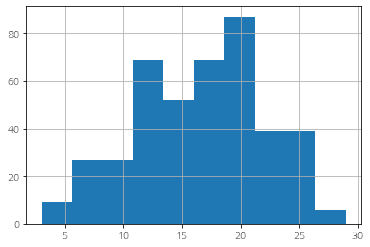

In [34]:
df_final['수요지수'].hist()

### 현재 키움센터 개수와 비교

공식 = 동별 점수*91 / Sum(동별 점수의 합) - 현재 동별 센터의 개수

In [35]:
df_supply = pd.read_pickle('/content/drive/My Drive/Project/Seoul/가공데이터/행정동별_주변공적돌봄시설.pickle')
df_supply

,행정동코드,시군구명,읍면동명,키움센터_상시돌봄정원,키움센터_일시돌봄정원,키움센터_개수,초등돌봄교실_이용인원,초등돌봄교실_교실개수,지역아동센터_정원,지역아동센터_개수,방과후아카데미_정원,방과후아카데미_개수
0,1111053000,종로구,사직동,0.0,0.0,0.0,65.0,3.0,0.0,0.0,0.0,0.0
1,1111054000,종로구,삼청동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1111055000,종로구,부암동,0.0,0.0,0.0,111.0,5.0,0.0,0.0,0.0,0.0
3,1111056000,종로구,평창동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1111057000,종로구,무악동,0.0,0.0,0.0,80.0,4.0,35.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
420,1174070000,강동구,둔촌제2동,0.0,0.0,0.0,153.0,7.0,50.0,1.0,0.0,0.0
421,1174057000,강동구,암사제1동,20.0,4.0,1.0,97.0,4.0,71.0,2.0,0.0,0.0
422,1174061000,강동구,천호제2동,0.0,0.0,0.0,100.0,4.0,59.0,2.0,0.0,0.0
423,1174068500,강동구,길동,0.0,0.0,0.0,255.0,13.0,129.0,5.0,0.0,0.0


In [36]:
Sum = df_final['수요지수'].sum()
print(Sum)

df_final['동별_필요센터수'] = df_final[['수요지수']].apply(lambda x: x*400 / Sum)
df_final

6996


,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수
0,1135059500,노원구,공릉1동,10,9,10,29,1.658090
1,1138062500,은평구,역촌동,8,10,10,28,1.600915
2,1150054000,강서구,화곡1동,9,9,10,28,1.600915
3,1132051100,도봉구,창1동,10,8,9,27,1.543739
4,1129070500,성북구,종암동,8,10,9,27,1.543739
...,...,...,...,...,...,...,...,...
419,1114052000,중구,소공동,2,1,1,4,0.228702
420,1117070000,용산구,보광동,2,1,1,4,0.228702
421,1117064000,용산구,이촌2동,2,1,1,4,0.228702
422,1174069000,강동구,둔촌1동,1,1,2,4,0.228702


In [37]:
df_final.merge(df_supply[['행정동코드', '키움센터_개수']])

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수
0,1135059500,노원구,공릉1동,10,9,10,29,1.658090,1.0
1,1138062500,은평구,역촌동,8,10,10,28,1.600915,1.0
2,1150054000,강서구,화곡1동,9,9,10,28,1.600915,0.0
3,1132051100,도봉구,창1동,10,8,9,27,1.543739,1.0
4,1129070500,성북구,종암동,8,10,9,27,1.543739,0.0
...,...,...,...,...,...,...,...,...,...
419,1114052000,중구,소공동,2,1,1,4,0.228702,0.0
420,1117070000,용산구,보광동,2,1,1,4,0.228702,1.0
421,1117064000,용산구,이촌2동,2,1,1,4,0.228702,1.0
422,1174069000,강동구,둔촌1동,1,1,2,4,0.228702,0.0


In [38]:
df_merge = df_final.merge(df_supply[['행정동코드', '키움센터_개수']])
df_merge['공급미달량'] = df_merge[['동별_필요센터수', '키움센터_개수']].apply(lambda x: x['동별_필요센터수']-x['키움센터_개수'], axis=1)
df_merge

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량
0,1135059500,노원구,공릉1동,10,9,10,29,1.658090,1.0,0.658090
1,1138062500,은평구,역촌동,8,10,10,28,1.600915,1.0,0.600915
2,1150054000,강서구,화곡1동,9,9,10,28,1.600915,0.0,1.600915
3,1132051100,도봉구,창1동,10,8,9,27,1.543739,1.0,0.543739
4,1129070500,성북구,종암동,8,10,9,27,1.543739,0.0,1.543739
...,...,...,...,...,...,...,...,...,...,...
419,1114052000,중구,소공동,2,1,1,4,0.228702,0.0,0.228702
420,1117070000,용산구,보광동,2,1,1,4,0.228702,1.0,-0.771298
421,1117064000,용산구,이촌2동,2,1,1,4,0.228702,1.0,-0.771298
422,1174069000,강동구,둔촌1동,1,1,2,4,0.228702,0.0,0.228702


In [39]:
# 1순위 -> 먼저 설치해야 함
pt_list = np.percentile(df_merge[['수요지수']],[i*10 for i in range(2,10,2)]).tolist()

df_merge['수요지수_우선순위'] = 0
df_merge.loc[df_merge['수요지수'] <= pt_list[0], '수요지수_우선순위'] = 5
df_merge.loc[(df_merge['수요지수'] > pt_list[0]) & (df_merge['수요지수'] <= pt_list[1]),'수요지수_우선순위'] = 4
df_merge.loc[(df_merge['수요지수'] > pt_list[1]) & (df_merge['수요지수'] <= pt_list[2]),'수요지수_우선순위'] = 3
df_merge.loc[(df_merge['수요지수'] > pt_list[2]) & (df_merge['수요지수'] <= pt_list[3]),'수요지수_우선순위'] = 2
df_merge.loc[(df_merge['수요지수'] > pt_list[3]),'수요지수_우선순위'] = 1
df_merge

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위
0,1135059500,노원구,공릉1동,10,9,10,29,1.658090,1.0,0.658090,1
1,1138062500,은평구,역촌동,8,10,10,28,1.600915,1.0,0.600915,1
2,1150054000,강서구,화곡1동,9,9,10,28,1.600915,0.0,1.600915,1
3,1132051100,도봉구,창1동,10,8,9,27,1.543739,1.0,0.543739,1
4,1129070500,성북구,종암동,8,10,9,27,1.543739,0.0,1.543739,1
...,...,...,...,...,...,...,...,...,...,...,...
419,1114052000,중구,소공동,2,1,1,4,0.228702,0.0,0.228702,5
420,1117070000,용산구,보광동,2,1,1,4,0.228702,1.0,-0.771298,5
421,1117064000,용산구,이촌2동,2,1,1,4,0.228702,1.0,-0.771298,5
422,1174069000,강동구,둔촌1동,1,1,2,4,0.228702,0.0,0.228702,5


In [40]:
# 1순위 -> 먼저 설치해야 함
pt_list = np.percentile(df_merge[['공급미달량']],[i*10 for i in range(2,10,2)]).tolist()

df_merge['공급미달량_우선순위'] = 0
df_merge.loc[df_merge['공급미달량'] <= pt_list[0], '공급미달량_우선순위'] = 5
df_merge.loc[(df_merge['공급미달량'] > pt_list[0]) & (df_merge['공급미달량'] <= pt_list[1]),'공급미달량_우선순위'] = 4
df_merge.loc[(df_merge['공급미달량'] > pt_list[1]) & (df_merge['공급미달량'] <= pt_list[2]),'공급미달량_우선순위'] = 3
df_merge.loc[(df_merge['공급미달량'] > pt_list[2]) & (df_merge['공급미달량'] <= pt_list[3]),'공급미달량_우선순위'] = 2
df_merge.loc[(df_merge['공급미달량'] > pt_list[3]),'공급미달량_우선순위'] = 1
df_merge

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위,공급미달량_우선순위
0,1135059500,노원구,공릉1동,10,9,10,29,1.658090,1.0,0.658090,1,4
1,1138062500,은평구,역촌동,8,10,10,28,1.600915,1.0,0.600915,1,4
2,1150054000,강서구,화곡1동,9,9,10,28,1.600915,0.0,1.600915,1,1
3,1132051100,도봉구,창1동,10,8,9,27,1.543739,1.0,0.543739,1,4
4,1129070500,성북구,종암동,8,10,9,27,1.543739,0.0,1.543739,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1114052000,중구,소공동,2,1,1,4,0.228702,0.0,0.228702,5,5
420,1117070000,용산구,보광동,2,1,1,4,0.228702,1.0,-0.771298,5,5
421,1117064000,용산구,이촌2동,2,1,1,4,0.228702,1.0,-0.771298,5,5
422,1174069000,강동구,둔촌1동,1,1,2,4,0.228702,0.0,0.228702,5,5


## t-NSE (1,1,1)

In [41]:
df_tsne_2 = df_tsne.merge(df_merge[['행정동코드', '공급미달량_우선순위', '수요지수_우선순위']], left_on='행정동코드', right_on='행정동코드')
df_tsne_2

,행정동코드,시군구명,행정동명,인프라지수,틈새돌봄인구,추정소득,공급미달량_우선순위,수요지수_우선순위
0,1165065100,서초구,양재1동,2.911910e-05,20.058894,0.651861,5,4
1,1153078000,구로구,오류제2동,7.399572e-05,15.328145,0.165374,5,2
2,1150063000,강서구,방화제1동,9.837376e-05,17.737957,-0.048502,5,1
3,1138069000,은평구,진관동,5.887938e-05,24.789692,-0.214553,5,2
4,1138062500,은평구,역촌동,1.043019e-04,11.221457,-1.179392,4,1
...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,5.739099e-07,0.464104,-0.509803,4,5
420,1114059000,중구,광희동,1.084052e-06,0.438543,0.281250,5,5
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,-0.023982,5,5
422,1114060500,중구,을지로동,1.870521e-07,0.108253,-0.692454,4,5


In [42]:
X = df_tsne_2[['인프라지수', '틈새돌봄인구', '추정소득']]

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

features = ['인프라지수', '틈새돌봄인구', '추정소득']
pd.DataFrame(X_scale, columns = features).head()

,인프라지수,틈새돌봄인구,추정소득
0,0.112843,0.771715,0.375769
1,0.287029,0.589386,0.277766
2,0.381651,0.682263,0.234681
3,0.228355,0.954046,0.201231
4,0.404660,0.431110,0.006865


In [44]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate= 100) 

#학습도니 tsne 모델을 이용해 data 변환: 차원 축소
data_tsne = tsne.fit_transform(X_scale)
print("원본 데이터의 형태: ", str(X_scale.shape))
print("축소된 데이터의 형태: ", str(data_tsne.shape))

원본 데이터의 형태:  (424, 3)
축소된 데이터의 형태:  (424, 2)


쿨백-라이블러 발산(Kullback–Leibler divergence, KLD)은 두 확률분포의 차이를 계산하는 데에 사용하는 함수로, 어떤 이상적인 분포에 대해, 그 분포를 근사하는 다른 분포를 사용해 샘플링을 한다면 발생할 수 있는 정보 엔트로피 차이를 계산한다. 상대 엔트로피(relative entropy), 정보 획득량(information gain), 인포메이션 다이버전스(information divergence)라고도 한다.

In [45]:
tsne.kl_divergence_

0.5811371803283691

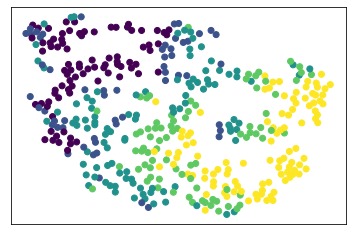

In [46]:
figure, axesSubplot = plt.subplots()

axesSubplot.scatter(data_tsne[:, 0], data_tsne[:, 1], c = df_tsne_2['수요지수_우선순위'])

axesSubplot.set_xticks(())

axesSubplot.set_yticks(())
plt.show()

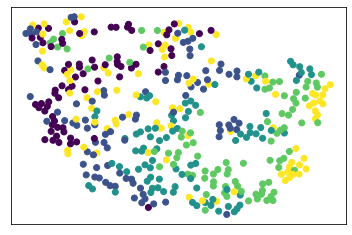

In [47]:
figure, axesSubplot = plt.subplots()

axesSubplot.scatter(data_tsne[:, 0], data_tsne[:, 1], c = df_tsne_2['공급미달량_우선순위'])

axesSubplot.set_xticks(())

axesSubplot.set_yticks(())
plt.show()

In [48]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate= 400, n_components=1, perplexity=50) 

#학습도니 tsne 모델을 이용해 data 변환: 차원 축소
data_tsne = tsne.fit_transform(X_scale)
print("원본 데이터의 형태: ", str(X_scale.shape))
print("축소된 데이터의 형태: ", str(data_tsne.shape))

원본 데이터의 형태:  (424, 3)
축소된 데이터의 형태:  (424, 1)


쿨백-라이블러 발산(Kullback–Leibler divergence, KLD)은 두 확률분포의 차이를 계산하는 데에 사용하는 함수로, 어떤 이상적인 분포에 대해, 그 분포를 근사하는 다른 분포를 사용해 샘플링을 한다면 발생할 수 있는 정보 엔트로피 차이를 계산한다. 상대 엔트로피(relative entropy), 정보 획득량(information gain), 인포메이션 다이버전스(information divergence)라고도 한다.

In [ ]:
tsne.kl_divergence_

1.0229301452636719

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


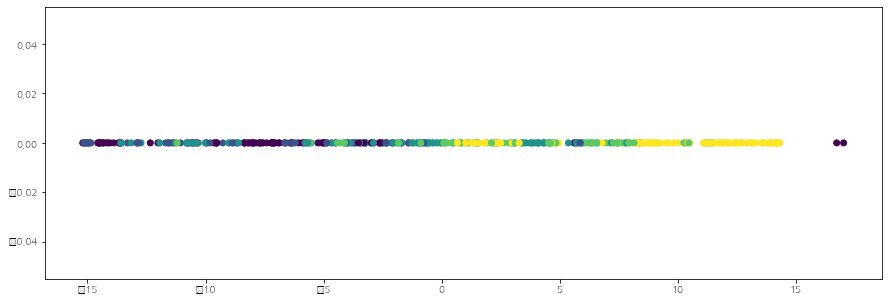

In [ ]:
val = 0
plt.figure(figsize=(15,5))
plt.scatter(data_tsne,np.zeros_like(data_tsne) + val,  c = df_tsne_2['수요지수_우선순위'])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


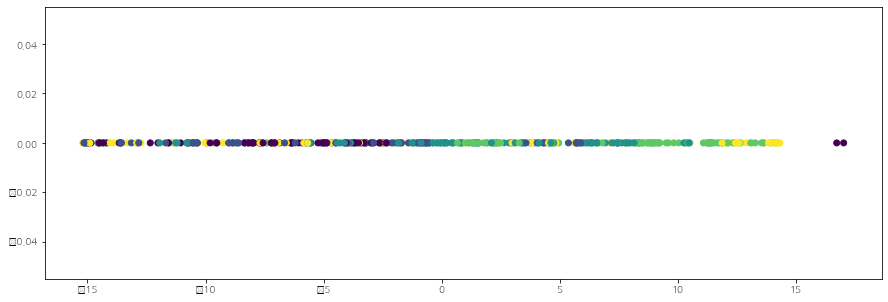

In [ ]:
val = 0
plt.figure(figsize=(15,5))
plt.scatter(data_tsne,np.zeros_like(data_tsne) + val,  c = df_tsne_2['공급미달량_우선순위'])

In [ ]:
df_tsne_result2 = pd.concat([df_tsne_2, pd.DataFrame(data_tsne.flatten(), columns = ['tsne'])], axis=1)
df_tsne_result2

,행정동코드,시군구명,행정동명,인프라지수,틈새돌봄인구,추정소득,공급미달량_우선순위,수요지수_우선순위,tsne
0,1165065100,서초구,양재1동,2.911910e-05,20.058894,0.651861,5,4,-10.758801
1,1153078000,구로구,오류제2동,7.399572e-05,15.328145,0.165374,5,2,-10.314933
2,1150063000,강서구,방화제1동,9.837376e-05,17.737957,-0.048502,5,1,-10.493538
3,1138069000,은평구,진관동,5.887938e-05,24.789692,-0.214553,5,2,-10.739532
4,1138062500,은평구,역촌동,1.043019e-04,11.221457,-1.179392,4,1,-8.013670
...,...,...,...,...,...,...,...,...,...
419,1114057000,중구,필동,5.739099e-07,0.464104,-0.509803,4,5,9.017559
420,1114059000,중구,광희동,1.084052e-06,0.438543,0.281250,5,5,14.247908
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,-0.023982,5,5,14.325463
422,1114060500,중구,을지로동,1.870521e-07,0.108253,-0.692454,4,5,8.997952


In [ ]:
df_tsne_result2.sort_values('tsne',ascending=True)

,행정동코드,시군구명,행정동명,인프라지수,틈새돌봄인구,추정소득,공급미달량_우선순위,수요지수_우선순위,tsne
97,1132052100,도봉구,도봉제1동,2.436601e-04,2.880405,-0.847441,5,1,-15.201262
290,1130560300,강북구,번2동,2.247890e-04,2.354255,-0.656235,2,2,-15.151104
18,1147058000,양천구,신월3동,2.279187e-04,3.421012,-0.746035,1,1,-15.123644
226,1126055000,중랑구,면목제5동,1.968087e-04,1.644651,-0.779982,2,2,-15.119394
138,1129064000,성북구,정릉제3동,1.942846e-04,2.048786,-0.609190,2,2,-15.058064
...,...,...,...,...,...,...,...,...,...
416,1162069500,관악구,신림동,5.627505e-07,1.142016,0.110989,5,5,14.242894
420,1114059000,중구,광희동,1.084052e-06,0.438543,0.281250,5,5,14.247908
421,1111054000,종로구,삼청동,1.052168e-06,0.449193,-0.023982,5,5,14.325463
294,1171068000,송파구,잠실3동,1.836798e-04,14.454883,1.045403,1,1,16.735880


In [ ]:
# 1, 1, 1 기준 

mask1 = df_merge['행정동코드'] == 1132052100
mask2 = df_merge['행정동코드'] == 1130560300
mask3 = df_merge['행정동코드'] == 1147058000
mask4 = df_merge['행정동코드'] == 1126055000
mask5 = df_merge['행정동코드'] == 1129064000

df_merge[mask1|mask2|mask3|mask4|mask5]

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위,공급미달량_우선순위
53,1132052100,도봉구,도봉1동,10,3,10,23,1.315037,1.0,0.315037,1,5
55,1147058000,양천구,신월3동,10,4,9,23,1.315037,0.0,1.315037,1,1
109,1129064000,성북구,정릉3동,10,2,8,20,1.143511,0.0,1.143511,2,2
124,1126055000,중랑구,면목5동,10,1,9,20,1.143511,0.0,1.143511,2,2
127,1130560300,강북구,번2동,10,2,8,20,1.143511,0.0,1.143511,2,2


In [ ]:
df_merge.sort_values('수요지수',ascending=False)

,행정동코드,시군구명,행정동명,인프라지수_분위,틈새돌봄인구_분위,소득_분위,수요지수,동별_필요센터수,키움센터_개수,공급미달량,수요지수_우선순위,공급미달량_우선순위
0,1135059500,노원구,공릉1동,10,9,10,29,1.658090,1.0,0.658090,1,4
2,1138062500,은평구,역촌동,8,10,10,28,1.600915,1.0,0.600915,1,4
1,1150054000,강서구,화곡1동,9,9,10,28,1.600915,0.0,1.600915,1,1
3,1132051100,도봉구,창1동,10,8,9,27,1.543739,1.0,0.543739,1,4
4,1129070500,성북구,종암동,8,10,9,27,1.543739,0.0,1.543739,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
419,1114052000,중구,소공동,2,1,1,4,0.228702,0.0,0.228702,5,5
420,1117070000,용산구,보광동,2,1,1,4,0.228702,1.0,-0.771298,5,5
421,1117064000,용산구,이촌2동,2,1,1,4,0.228702,1.0,-0.771298,5,5
422,1174069000,강동구,둔촌1동,1,1,2,4,0.228702,0.0,0.228702,5,5
